This notebook used a model which is pretrained on 0-100% C fraction dataset, and evaluated it on 0-10% C fraction data to check if there also exist edge bias problem.

In [12]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [13]:
root_dir = "/unix/erw/data/24-07-25/batch_output"
root_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".root")]

all_elements = set()
for path in root_files:
    with uproot.open(path) as file:
        # set(elements)
        df = file["Materials"].arrays(library="pd")
        all_elements.update(df["Element"].unique())
        
element_list = sorted(list(all_elements))
element_to_index = {el: i for i, el in enumerate(element_list)}


X = [] 
Y = [] 

for path in root_files:
    with uproot.open(path) as file:

        spectrum = file["Edep (noise)"].values()
        #spectrum = file["Edep"].values()

        # min-max scale normalization
        spectrum_min = np.min(spectrum)
        spectrum_max = np.max(spectrum)
        if spectrum_max > spectrum_min:
            spectrum = (spectrum - spectrum_min) / (spectrum_max - spectrum_min)
        else:
            spectrum = np.zeros_like(spectrum)

        spectrum = spectrum.astype(np.float32)
        X.append(spectrum)

        df = file["Materials"].arrays(library="pd")
        df = df.drop_duplicates()           # Don't forget!!!
        target = np.zeros(len(element_list), dtype=np.float32)
        for _, row in df.iterrows():
            idx = element_to_index[row["Element"]]
            target[idx] += row["Fraction"]
        Y.append(target)


X = torch.tensor(np.stack(X)).unsqueeze(1)  # shape: [N, 1, 1440]
Y = torch.tensor(np.stack(Y))               # shape: [N, num_elements]

['C', 'O', 'Si']


In [14]:
class cCNN_MDN(nn.Module):
    def __init__(self, num_elements=3, num_mixtures=3):
        super().__init__()
        self.num_elements = num_elements  # D -- dimension of target vector
        self.num_mixtures = num_mixtures  # M -- number of Gaussian mixture components

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, padding=4),   # [B, 64, 1440]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 32, 360]

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180]
        )

        self.flatten_dim = 128 * 180  # update it if input structure changes

        self.hidden = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),
            #nn.Dropout(0.3),
        )

        # Output heads:
        self.pi_layer = nn.Linear(64, num_mixtures)                    # [B, M]
        self.mu_layer = nn.Linear(64, num_mixtures * num_elements)     # [B, M*D]
        self.sigma_layer = nn.Linear(64, num_mixtures * num_elements)  # [B, M*D]

    def forward(self, x):
        B = x.size(0)
        x = self.conv_layers(x)
        x = x.view(B, -1)
        x = self.hidden(x)

        # Output parameters : pi, mu, sigma
        pi = F.softmax(self.pi_layer(x), dim=1)  # [B, M]

        mu = self.mu_layer(x).view(B, self.num_mixtures, self.num_elements)  # [B, M, D]
        mu = F.softmax(mu, dim=2)  # fraction (0~1, sum=1)

        sigma = torch.exp(self.sigma_layer(x).view(B, self.num_mixtures, self.num_elements))  # [B, M, D]

        return pi, mu, sigma

In [15]:
batch_size = 32

dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [16]:
# Recall model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cCNN_MDN(num_elements=3, num_mixtures=1).to(device)
model.load_state_dict(torch.load("MDN_pretrained_fullC.pt", map_location=device))

<All keys matched successfully>

In [17]:
def mdn_predict_mean(pi, mu):
    return torch.sum(pi.unsqueeze(-1) * mu, dim=1)  # [B, D]

def mdn_predict_std(pi, mu, sigma):
    # Expected mean: E[y] = sum(pi * mu)
    mean = torch.sum(pi.unsqueeze(2) * mu, dim=1)  # shape: [B, D]

    # Variance: Var[y] = sum(pi * (sigma^2 + (mu - E[y])^2))
    var = torch.sum(
        pi.unsqueeze(2) * (sigma ** 2 + (mu - mean.unsqueeze(1)) ** 2),
        dim=1
    )  # shape: [B, D]

    std = torch.sqrt(var + 1e-8)
    return std

In [18]:
model.eval()

all_preds = []
all_targets = []
all_stds = []

all_pi = []
all_mu = []
all_sigma = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X = val_X.to(device)
        val_Y = val_Y.to(device)

        pi, mu, sigma = model(val_X)            # [B, M], [B, M, D], [B, M, D]
        y_pred = mdn_predict_mean(pi, mu)       # [B, D]
        y_std = mdn_predict_std(pi, mu, sigma)  # [B, D]

        all_preds.append(y_pred.cpu())
        all_targets.append(val_Y.cpu())
        all_stds.append(y_std.cpu())

        all_pi.append(pi.cpu())
        all_mu.append(mu.cpu())
        all_sigma.append(sigma.cpu())

all_preds = torch.cat(all_preds, dim=0)         # [N, D]
all_targets = torch.cat(all_targets, dim=0)     # [N, D]
all_stds = torch.cat(all_stds, dim=0)           # [N, D]

all_pi = torch.cat(all_pi, dim=0)               # [N, M]
all_mu = torch.cat(all_mu, dim=0)               # [N, M, D]
all_sigma = torch.cat(all_sigma, dim=0)         # [N, M, D]

print(all_preds.shape)
print(all_stds.shape)
print(all_pi.shape)

torch.Size([200, 3])
torch.Size([200, 3])
torch.Size([200, 1])


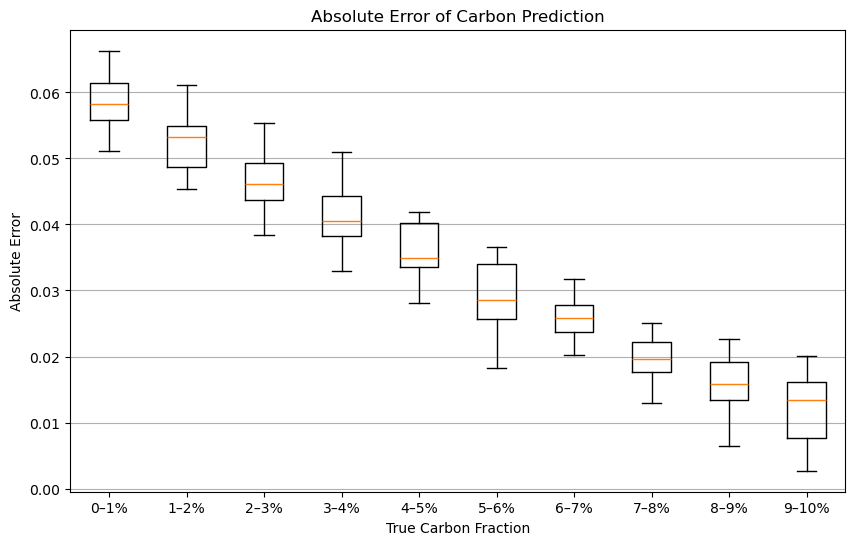

In [19]:
carbon_index = 0
true_C = all_targets[:, carbon_index].numpy()
pred_C = all_preds[:, carbon_index].numpy()
abs_errors = np.abs(true_C - pred_C)

# bins：0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect abs error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, abs_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

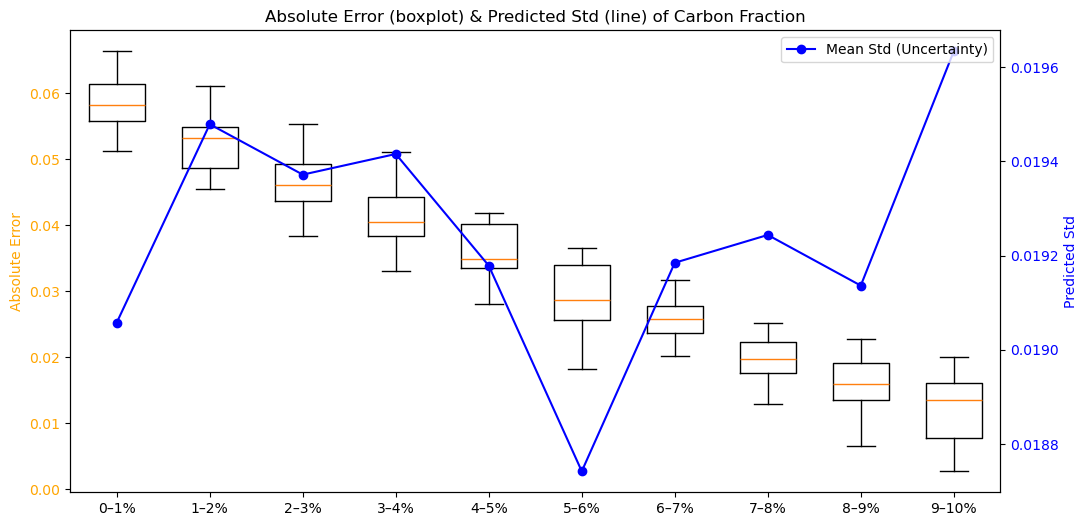

In [22]:
# Add std line plot

std_C = all_stds[:, carbon_index].numpy() 

# bins：0-10%, 10-20%, ..., 90-100%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]
bin_indices = np.digitize(true_C, bins) - 1  # Bin index: 0 to 9

# Correct abs error and stf in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
grouped_stds = [[] for _ in range(len(bins) - 1)]
for idx, err, std in zip(bin_indices, abs_errors, std_C):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)
        grouped_stds[idx].append(std)

# mean std for each bin
std_means = [np.mean(s) if len(s) > 0 else 0 for s in grouped_stds]
#print(std_means)
x_pos = np.arange(len(bin_labels))

# plot
# left: boxplot; right: std
fig, ax1 = plt.subplots(figsize=(12, 6))

# Boxplot for abs error
box = ax1.boxplot(grouped_errors, positions=x_pos, widths=0.6)
ax1.set_ylabel("Absolute Error", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# Line plot for std
ax2 = ax1.twinx()
ax2.plot(x_pos, std_means, color="blue", marker="o", label="Mean Std (Uncertainty)")
ax2.set_ylabel("Predicted Std", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.legend(loc="upper right")

plt.xticks(x_pos, bin_labels)
plt.title("Absolute Error (boxplot) & Predicted Std (line) of Carbon Fraction")
plt.show()

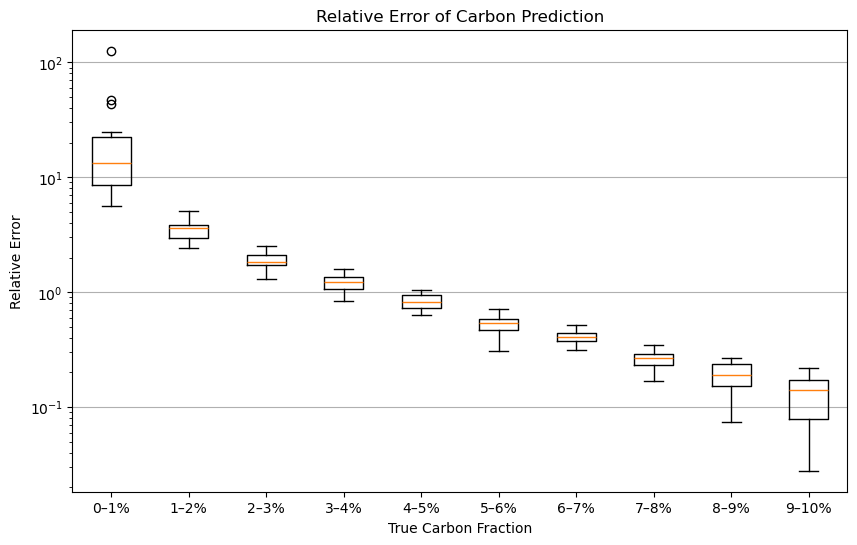

In [21]:
# Relative Error

rel_errors = np.abs(true_C - pred_C) / np.clip(true_C, 1e-6, None) # avoid 0

# bins：0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect rel error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, rel_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.yscale("log")
plt.xlabel("True Carbon Fraction")
plt.ylabel("Relative Error")
plt.title("Relative Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

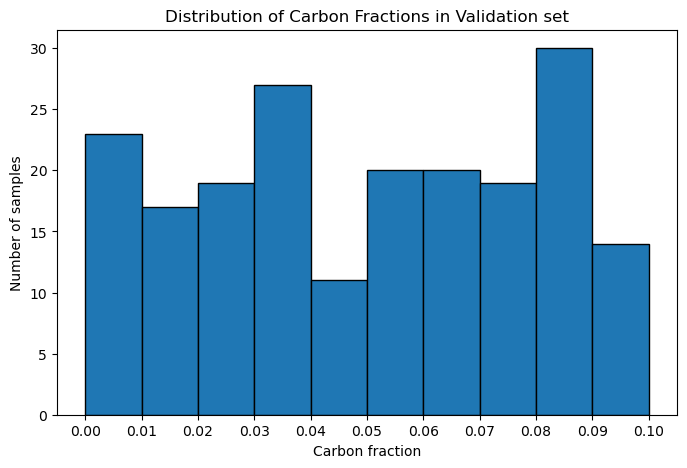

In [20]:
bins = [i/100 for i in range(11)]

plt.figure(figsize=(8, 5))
plt.hist(true_C, bins=bins, edgecolor="black")
plt.xlabel("Carbon fraction")
plt.ylabel("Number of samples")
plt.title("Distribution of Carbon Fractions in Validation set")
plt.xticks(bins)
plt.show()